# Customer Segmentation (Clustering)

## Business Objective
The goal of this project is to segment customers into distinct groups based on behavior, tenure, and value metrics.  
These segments can be used to support targeted marketing, personalized retention strategies, and pricing decisions.

## Approach
We will use unsupervised learning (K-Means clustering) to identify natural customer groupings.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
df = pd.read_excel("data/raw/Telco_customer_churn.xlsx")
df.shape, df.head()

((7043, 33),
    CustomerID  Count        Country       State         City  Zip Code  \
 0  3668-QPYBK      1  United States  California  Los Angeles     90003   
 1  9237-HQITU      1  United States  California  Los Angeles     90005   
 2  9305-CDSKC      1  United States  California  Los Angeles     90006   
 3  7892-POOKP      1  United States  California  Los Angeles     90010   
 4  0280-XJGEX      1  United States  California  Los Angeles     90015   
 
                  Lat Long   Latitude   Longitude  Gender  ...        Contract  \
 0  33.964131, -118.272783  33.964131 -118.272783    Male  ...  Month-to-month   
 1   34.059281, -118.30742  34.059281 -118.307420  Female  ...  Month-to-month   
 2  34.048013, -118.293953  34.048013 -118.293953  Female  ...  Month-to-month   
 3  34.062125, -118.315709  34.062125 -118.315709  Female  ...  Month-to-month   
 4  34.039224, -118.266293  34.039224 -118.266293    Male  ...  Month-to-month   
 
   Paperless Billing             Payment 

In [3]:
seg_cols = [
    "Tenure Months",
    "Monthly Charges",
    "Total Charges",
    "CLTV"
]

df_seg = df[seg_cols].copy()
df_seg.head()

,Tenure Months,Monthly Charges,Total Charges,CLTV
0,2,53.85,108.15,3239
1,2,70.70,151.65,2701
2,8,99.65,820.5,5372
3,28,104.80,3046.05,5003
4,49,103.70,5036.3,5340


In [4]:
df_seg.isna().sum()

Tenure Months      0
Monthly Charges    0
Total Charges      0
CLTV               0
dtype: int64

In [6]:
# Fix blank strings in Total Charges, convert to numeric
df_seg["Total Charges"] = pd.to_numeric(df_seg["Total Charges"], errors="coerce")

# Fill any NaNs created by coercion (from blanks) with median
df_seg["Total Charges"] = df_seg["Total Charges"].fillna(df_seg["Total Charges"].median())

# quick sanity check
df_seg.dtypes, df_seg.isna().sum()

(Tenure Months        int64
 Monthly Charges    float64
 Total Charges      float64
 CLTV                 int64
 dtype: object,
 Tenure Months      0
 Monthly Charges    0
 Total Charges      0
 CLTV               0
 dtype: int64)

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_seg)

X_scaled.shape

(7043, 4)

## KMeans Clustering – Elbow Method

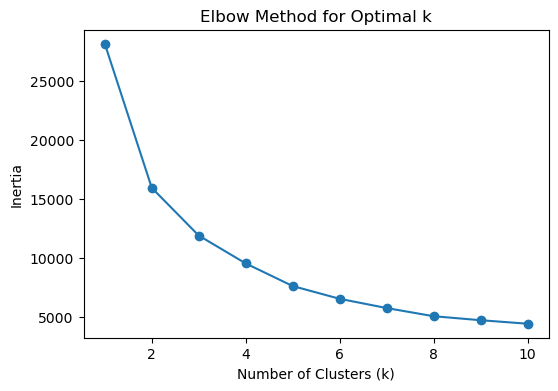

In [8]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []

K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertia, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

### Elbow Method Result

Based on the elbow method, **k = 3** was selected as the optimal number of clusters.  
The inertia decreases sharply up to k = 3, after which improvements become marginal.  
This suggests that three distinct customer segments capture the majority of the underlying structure in the data.

In [9]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

df_seg["Cluster"] = clusters
df_seg["Cluster"].value_counts()

Cluster
1    2516
0    2451
2    2076
Name: count, dtype: int64

## Customer Segment Profiles

The following table summarizes the average characteristics of each customer segment derived from KMeans clustering.

In [10]:
cluster_profile = (
    df_seg
    .groupby("Cluster")
    .agg({
        "Tenure Months": "mean",
        "Monthly Charges": "mean",
        "Total Charges": "mean",
        "CLTV": "mean"
    })
    .round(2)
)

cluster_profile

,Tenure Months,Monthly Charges,Total Charges,CLTV
Cluster,,,,
0,16.10,63.63,1046.61,3101.14
1,26.21,44.43,962.34,5086.44
2,59.05,90.74,5339.61,5102.55


### Customer Segment Interpretation

**Cluster 0 – New / Price-Sensitive Customers**
- Short tenure
- Moderate monthly charges
- Low total charges
- Lowest CLTV
- Represents early-stage or cost-conscious customers with higher churn risk

**Cluster 1 – Value-Oriented Loyal Customers**
- Moderate tenure
- Lower monthly charges
- Moderate total charges
- High CLTV
- Stable customers who generate strong lifetime value without high monthly spend

**Cluster 2 – High-Value Power Users**
- Longest tenure
- Highest monthly charges
- Highest total charges
- Highest CLTV
- Core revenue-driving customers with strong engagement and retention

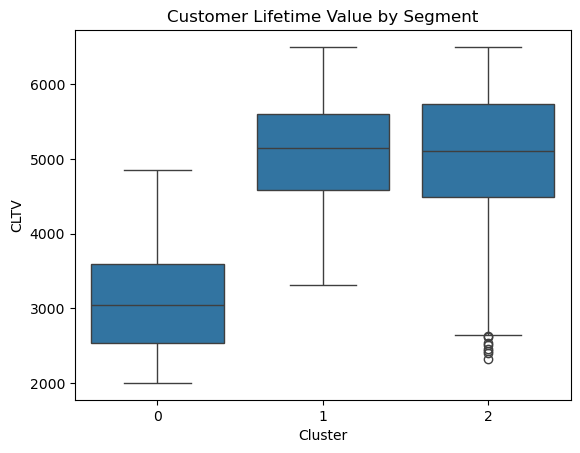

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=df_seg, x="Cluster", y="CLTV")
plt.title("Customer Lifetime Value by Segment")
plt.show()